In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim,utils,torch

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                              ])

In [3]:
trainset = datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transform)
valset = datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)
trainloader = utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = utils.data.DataLoader(valset, batch_size=64, shuffle=True)

In [4]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
#images=(images+1)/2
print(images.shape)
print(torch.max(images))
print(torch.min(images))
print(labels.shape)

torch.Size([64, 1, 28, 28])
tensor(1.)
tensor(0.)
torch.Size([64])


In [5]:
class autoencoder(nn.Module):
    input_size = 784
    hidden_sizes = [256, 32]
    output_size = 16
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(self.input_size, self.hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(self.hidden_sizes[0], self.hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(self.hidden_sizes[1], self.output_size))
        self.decoder = nn.Sequential(nn.Linear(self.output_size, self.hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(self.hidden_sizes[1], self.hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(self.hidden_sizes[0], self.input_size),
                      nn.Softmax())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
vanila_ae = autoencoder()
print(vanila_ae)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): Softmax(dim=None)
  )
)


In [6]:

images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = vanila_ae(images) #log probabilities

criterion = nn.BCELoss()

#tlabls = labelTransform(labels,10)
loss = criterion(logps,images) #calculate the loss


c:\Users\debon\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [7]:
print('Before backward pass: \n', vanila_ae.encoder[0].weight.grad)
loss.backward()
print('After backward pass: \n', vanila_ae.encoder[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


Epoch 0 - Training loss: 0.7009522795423008
Epoch 1 - Training loss: 0.6805030361675759
Epoch 2 - Training loss: 0.6762180991772649
Epoch 3 - Training loss: 0.6741298567384545
Epoch 4 - Training loss: 0.6727891188186369
Epoch 5 - Training loss: 0.6715647064165265
Epoch 6 - Training loss: 0.6707631977382245
Epoch 7 - Training loss: 0.6702808607488807
Epoch 8 - Training loss: 0.6697055138250404
Epoch 9 - Training loss: 0.6689185053427845
Epoch 10 - Training loss: 0.6681955253391632
Epoch 11 - Training loss: 0.6677230229255742
Epoch 12 - Training loss: 0.6674295331496419
Epoch 13 - Training loss: 0.6672282623710917
Epoch 14 - Training loss: 0.6671566635942154

Training Time (in minutes) = 5.67757115761439


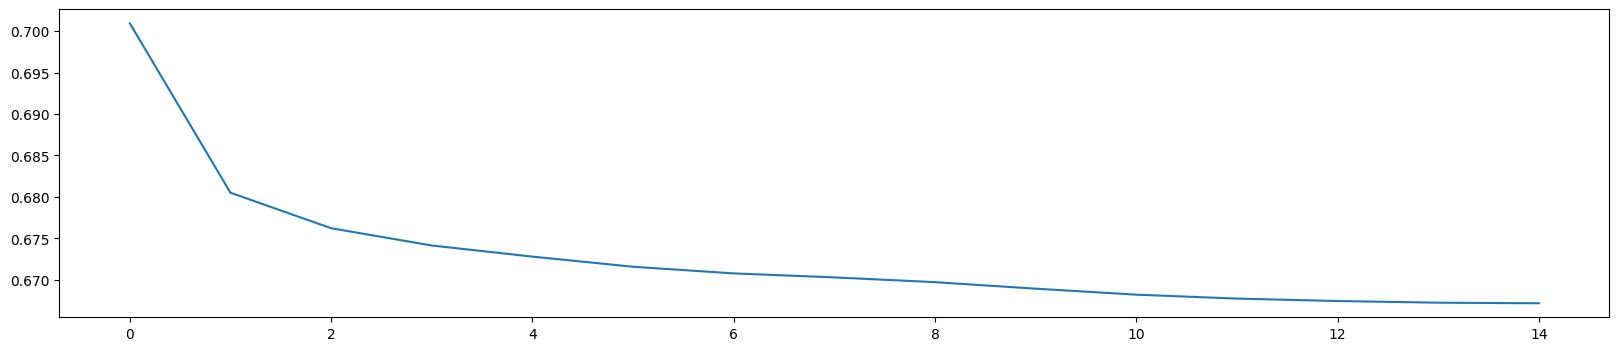

In [8]:
optimizer = optim.Adam(vanila_ae.parameters(), lr=0.003, weight_decay=1e-5)
time0 = time()
epochs = 15
loss_hist = []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        
        output = vanila_ae(images)
        loss = criterion(output, images)
        
        #This is where the model learns by backpropagating
        optimizer.zero_grad()
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
        loss_hist.append(running_loss/len(trainloader))
print("\nTraining Time (in minutes) =",(time()-time0)/60)
plt.figure(figsize=(20, 4))
plt.plot(loss_hist)
plt.show()

In [9]:
# To measure embeddings accuracy
# Using SVM to predict labels from embedings
train_images = torch.tensor([])
train_encoded = torch.tensor([])
train_labels = torch.tensor([])

for imgs, lbls in trainloader:
        imgs = imgs.view(imgs.shape[0], -1)
        en = vanila_ae.encoder(imgs)
        train_encoded=torch.cat((train_encoded,en))
        train_labels=torch.cat((train_labels,lbls))
        train_images=torch.cat((train_images,imgs))

print(train_encoded.shape)
print(train_labels.shape)
from sklearn.svm import SVC
clf =  SVC(gamma='auto')

with torch.no_grad():  
        clf.fit(train_encoded,train_labels)

torch.Size([60000, 16])
torch.Size([60000])


c:\Users\debon\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


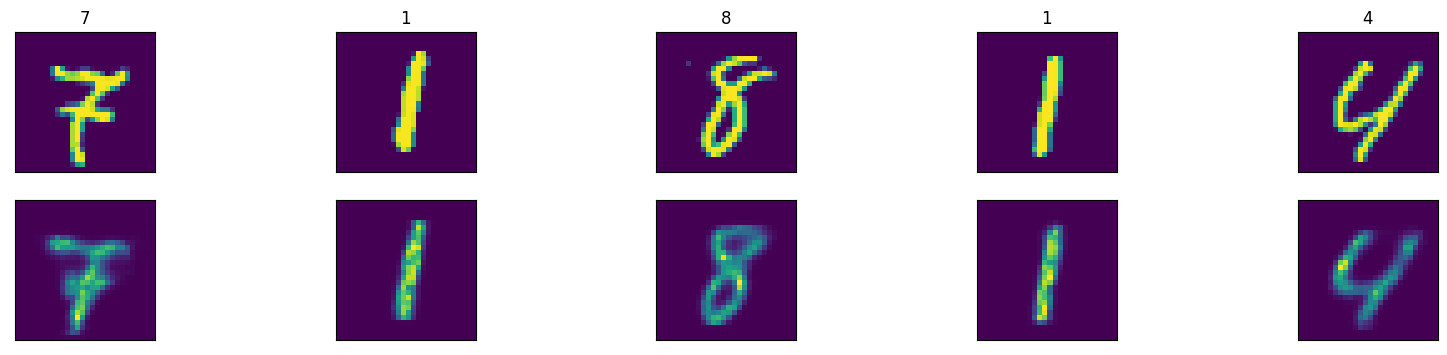

In [10]:
images, labels = next(iter(valloader))

img = images[0].view(1, 784)
with torch.no_grad():
    encoded = vanila_ae.encoder(images.view(-1, 784))
    decoded = vanila_ae.decoder(encoded)

plt.figure(figsize=(20, 4))
for i in range(5):
    # Display original
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].reshape(28, 28))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(labels[i].numpy())
    # Display reconstruction
    ax = plt.subplot(2, 5, i + 1 + 5)
    plt.imshow(decoded[i].reshape(28, 28))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [11]:
#preparing test embeddings

test_encoded = torch.tensor([])
test_labels = torch.tensor([])
test_images = torch.tensor([])

for imgs, lbls in valloader:
        imgs = imgs.view(imgs.shape[0], -1)
        en = vanila_ae.encoder(imgs)
        test_encoded=torch.cat((test_encoded,en))
        test_labels=torch.cat((test_labels,lbls))
        test_images=torch.cat((test_images,imgs))

print(test_encoded.shape)
print(test_labels.shape)

torch.Size([10000, 16])
torch.Size([10000])


In [12]:
with torch.no_grad():
        pred_labels = clf.predict(test_encoded)

*** Classification Report ***
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98       980
         1.0       0.99      0.98      0.99      1135
         2.0       0.93      0.98      0.95      1032
         3.0       0.86      0.97      0.91      1010
         4.0       0.98      0.96      0.97       982
         5.0       0.98      0.93      0.95       892
         6.0       0.99      0.96      0.98       958
         7.0       0.99      0.94      0.96      1028
         8.0       0.92      0.95      0.93       974
         9.0       0.97      0.93      0.95      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



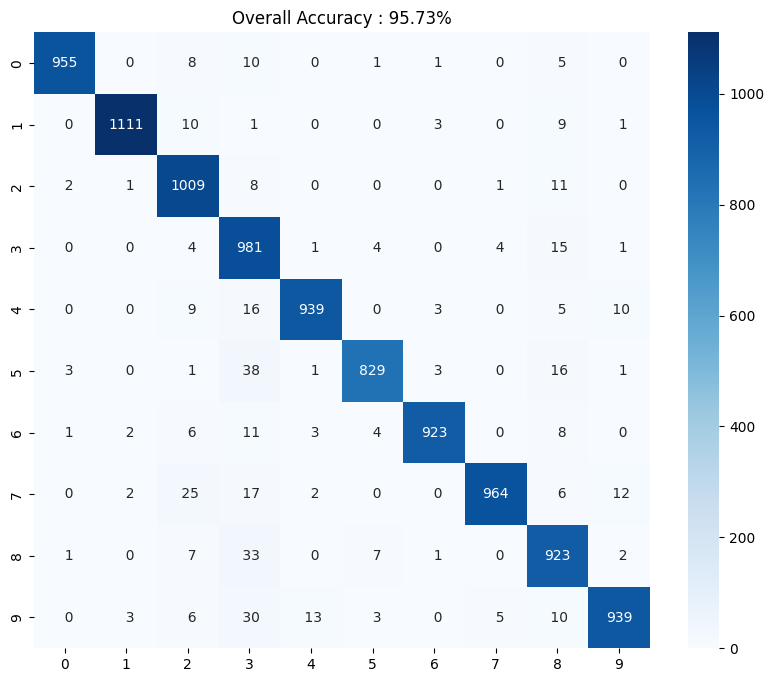

Classwise Accuracy Score: 

	0	1	2	3	4	5	6	7	8	9
	97.45	97.89	97.77	97.13	95.62	92.94	96.35	93.77	94.76	93.06

In [13]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import seaborn as sns

print('*** Classification Report ***')
print(classification_report(test_labels,pred_labels))
overallAccuracy = accuracy_score(test_labels,pred_labels)
cm = confusion_matrix(test_labels,pred_labels)
classwiseAccuracy = cm.diagonal()/cm.sum(axis=1)

plt.figure(figsize=(10, 8))
plt.title('Overall Accuracy : {0:3.2f}%'.format(overallAccuracy*100), size=12)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
sns.heatmap(data=cm, annot=True, square=True,  cmap='Blues',fmt='3.0f')

plt.show()

print('Classwise Accuracy Score: \n')

for i in range(10):
    print(f'\t{i}', end='')
print()
for acc in classwiseAccuracy:
    print(f'\t{acc*100:2.2f}', end='')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


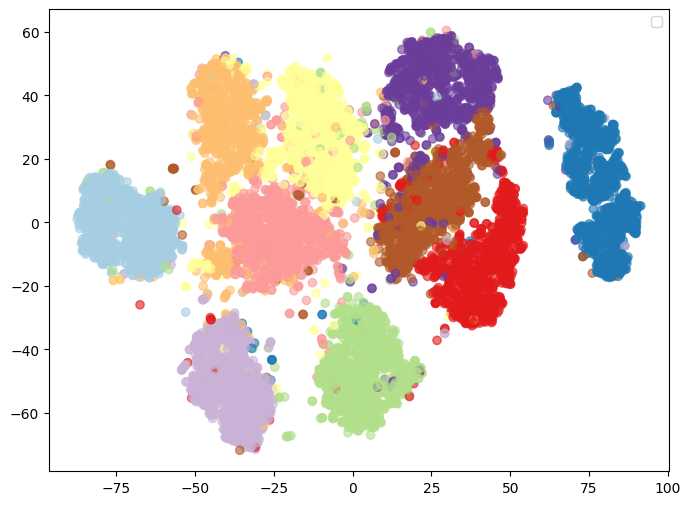

In [14]:
from sklearn.manifold import TSNE

plt.figure(figsize=(8, 6))
with torch.no_grad():
        X_embedded = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=40).fit_transform(test_encoded)
        plt.scatter(X_embedded[:,0],X_embedded[:,1], c=test_labels,cmap="Paired", alpha = 0.6,marker='o')
plt.legend()
plt.show()

In [15]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox

## Function to Scale and visualize the embedding vectors
def plot_embedding(X,y, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)     
    plt.figure(figsize=(12,10))
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})
    if hasattr(offsetbox, 'AnnotationBbox'):
        ## only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 20e-3:
                ## don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(test_images[i].reshape(28,28), cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)


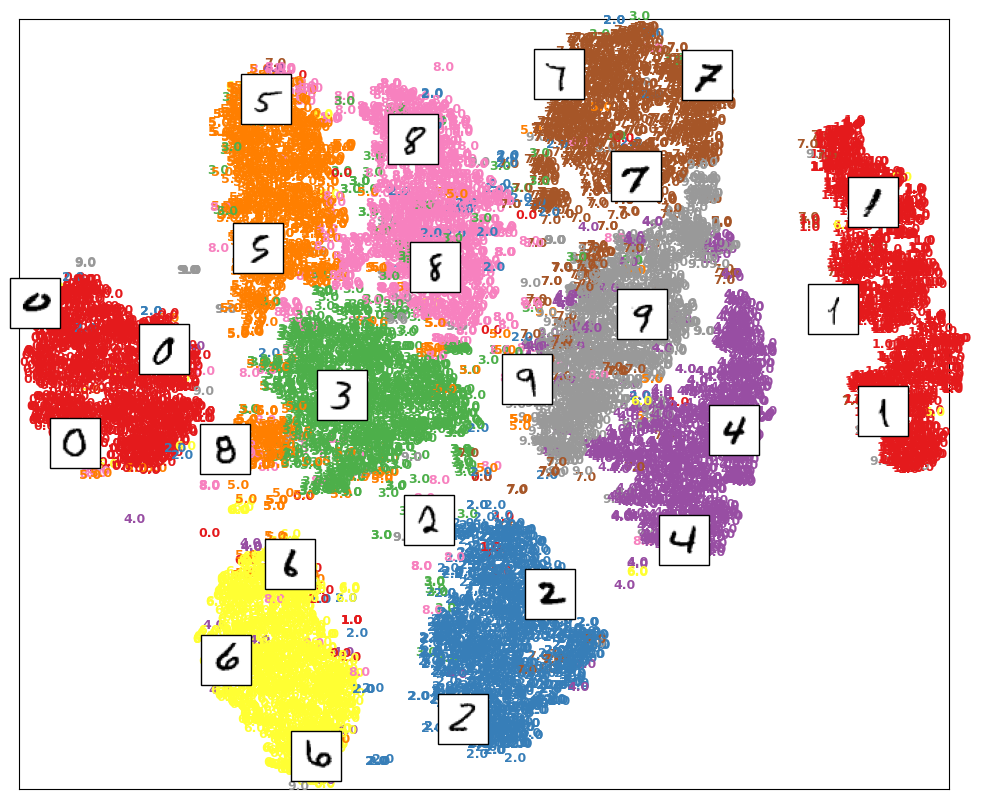

In [16]:
with torch.no_grad():
    plot_embedding(X_embedded,test_labels.numpy())

In [17]:
noise_factor = 0.7
x_train_noisy = images + noise_factor * torch.randn(*images.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
print(images[0][0][14])
print(x_train_noisy[0][0][14])

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.1725, 0.2471, 0.3490, 0.8000, 0.9922, 0.8980, 0.1529, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000])
tensor([0.0000, 0.2263, 0.0000, 0.0000, 0.0000, 0.0000, 0.9280, 0.0000, 0.1376,
        0.0000, 0.0000, 0.0000, 1.0000, 0.8289, 0.7107, 1.0000, 0.1526, 1.0000,
        0.0000, 0.3162, 0.9892, 0.0000, 0.0000, 0.8696, 0.4765, 0.0000, 0.3613,
        0.6350])


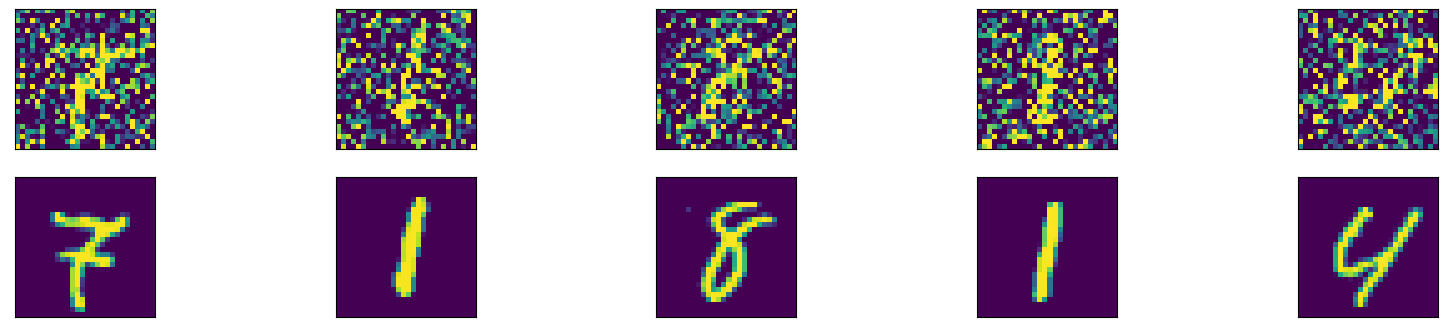

In [18]:
plt.figure(figsize=(20, 4))
for i in range(5):
    # Display original
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(x_train_noisy[i].reshape(28, 28))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, 5, i + 1 + 5)
    plt.imshow(images[i].reshape(28, 28))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

c:\Users\debon\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch 0 - Training loss: 0.7250571052657008
Epoch 1 - Training loss: 0.7041705520168297
Epoch 2 - Training loss: 0.7000817557387768
Epoch 3 - Training loss: 0.6976366400210334
Epoch 4 - Training loss: 0.6962181287152427

Training Time (in minutes) = 2.0813064495722453


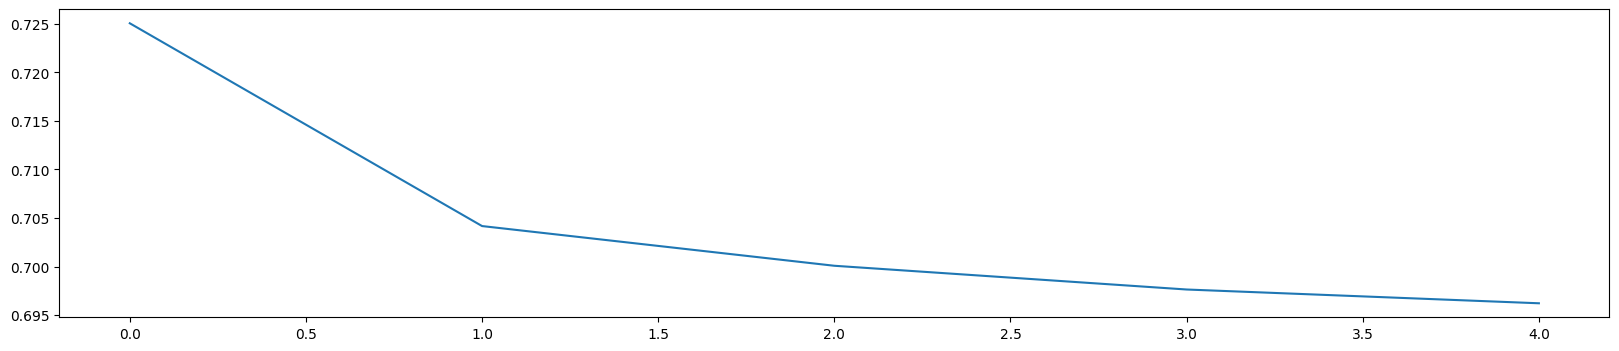

In [19]:
denoising_ae = autoencoder()
optimizer = optim.Adam(denoising_ae.parameters(), lr=0.003, weight_decay=1e-5)
time0 = time()
epochs = 5
loss_hist = []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        x_train_noisy = images + noise_factor * torch.randn(*images.shape)
        x_train_noisy = np.clip(x_train_noisy, 0., 1.)
        # Training pass
        
        output = denoising_ae(x_train_noisy)
        loss = criterion(output, images)
        
        #This is where the model learns by backpropagating
        optimizer.zero_grad()
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
        loss_hist.append(running_loss/len(trainloader))
print("\nTraining Time (in minutes) =",(time()-time0)/60)
plt.figure(figsize=(20, 4))
plt.plot(loss_hist)
plt.show()

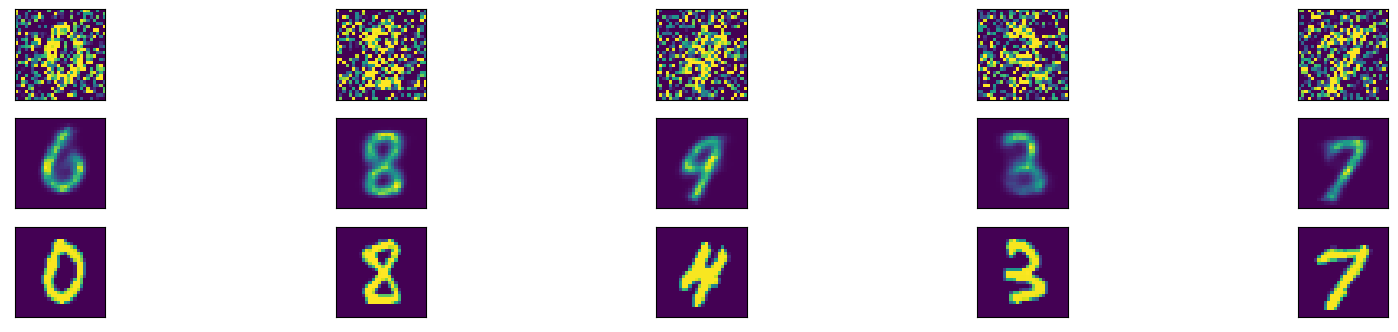

In [20]:
images, labels = next(iter(valloader))

x_train_noisy = images + noise_factor * torch.randn(*images.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
with torch.no_grad():
    denoised_images = denoising_ae(x_train_noisy.view(-1, 784))

plt.figure(figsize=(20, 4))
for i in range(5):
    # Display original
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(x_train_noisy[i].reshape(28, 28))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(3, 5, i + 1 + 5)
    plt.imshow(denoised_images[i].reshape(28, 28))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display reconstruction
    ax = plt.subplot(3, 5, i + 1 + 10)
    plt.imshow(images[i].reshape(28, 28))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()